### Copyright Preferred Computational Chemistry as contributors to Matlantis contrib project
# [JP] エポキシ樹脂（Bisphenol-A dimer diglycidyl ether）の熱分解シミュレーション
- エポキシ樹脂の熱分解反応は、プラスチックリサイクルのプロセス設計において重要です。通常、ポリマー分子の熱分解は高温で進行し、様々な小分子が生成されます。このような反応過程を扱う方法として、反応力場（ReaxFF）を用いた古典分子動力学（MD）シミュレーションが広く用いられています。これにより、分解反応を詳細に解析することが可能です。一方、ReaxFFは力場の作成が難しいという課題があります。そこで、学習済みの汎用ポテンシャルであるPFPを用いて同様の計算を行い、結果の検証を行いました（HPに公開済の事例から、PFPのバージョンと分子構造が変更されています）。  
https://matlantis.com/calculation/thermal-decomposition-of-epoxy-molecules  

- モデル化合物: Bisphenol-A dimer diglycidyl ether (formula: C<sub>39</sub>H<sub>44</sub>O<sub>7</sub>)  
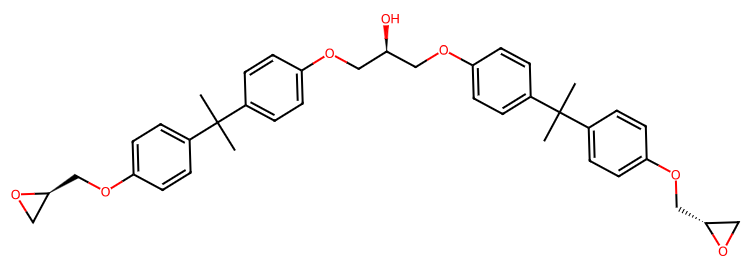
- reaxFFを使用したオリジナルの報告（Z. Diao et al., <I>Journal of Analytical and Applied Pyrolysis</I> <B>2013</B>, <I>104</I>, 618.）  
https://www.sciencedirect.com/science/article/abs/pii/S016523701300096X?via%3Dihub

- 計算の流れ  
1) ライブラリの読み込み  
2) 系の作成  
    - エポキシ樹脂モデルの読み込み・構造最適化
    - エポキシ樹脂モデル15分子の凝集構造作成
3) 熱分解シミュレーション  
    - 昇温速度違い（100, 250, 500 K/ps で 300 K から 2300 K まで）
    - 到達温度違い（500 ps/K で 300 K から 2800, 3300, 4300 K まで）
4) トラジェクトリー解析  
    - 昇温速度違い（元論文 Fig. 4）
    - 到達温度違い（元論文 Fig. 5）
    
# [EN] Simulations of epoxy resin (Bisphenol-A dimer diglycidyl ether) pyrolysis
- Thermal decomposition of epoxy resin is crucial in the design of plastic recycling processes. Typically, polymer molecules decompose into various small molecules at high temperatures. Such reaction processes can be simulated using classical molecular dynamics (MD) with a reactive force field (ReaxFF), which allows detailed analysis of decomposition reactions. However, fitting the force field parameters of ReaxFF is difficult. To address this, we have performed calculations using PFP, a pre-trained universal potential, and compared the results with ReaxFF (the PFP version and molecular structure have been changed from the example on the PFCC website.).  
https://matlantis.com/calculation/thermal-decomposition-of-epoxy-molecules  

- Model compound: Bisphenol-A dimer diglycidyl ether (formula: C<sub>39</sub>H<sub>44</sub>O<sub>7</sub>)  
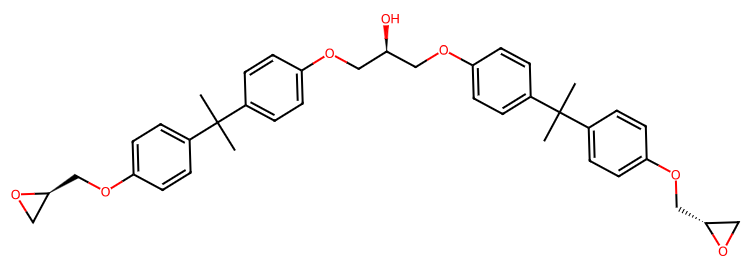
- Original report by using reaxFF（Z. Diao et al., <I>Journal of Analytical and Applied Pyrolysis</I> <B>2013</B>, <I>104</I>, 618.）  
https://www.sciencedirect.com/science/article/abs/pii/S016523701300096X?via%3Dihub

- Calculation flow  
1) Library import  
2) Target system construction  
    - Reading a model epoxy structure followed by geometry optimizations
    - Constructing a condensed structure consisted of 15 model epoxy molcules
3) Pyrolysis simulations
    - Different heating rates（from 300 K to 2300 K by 100, 250, and 500 K/ps）
    - Different target temperatures（from 300 K to 2800, 3300, 4300 K by 500 K/ps）
4) Trajectory analysis
    - Different heating rates (Fig. 4 in the original paper)
    - Different target temperatures (Fig. 5 in the original paper)

## 1. [JP]ライブラリの読み込み / [EN]Library import

In [1]:
import os

In [3]:
## PFP-API
from pfp_api_client import Estimator, ASECalculator

## Matlantis Features
from matlantis_features.utils.calculators import pfp_estimator_fn
from matlantis_features.atoms import MatlantisAtoms
from matlantis_features.features.common.opt import FireLBFGSASEOptFeature
from matlantis_features.features.md import (ASEMDSystem, MDFeature, MDExtensionBase,
                                            NVTBerendsenIntegrator, NPTIntegrator, NPTBerendsenIntegrator)
from matlantis_features.features.md.md_extensions import TemperatureScheduler


In [4]:


## PFCC_extras
from pfcc_extras.liquidgenerator.liquid_generator import LiquidGenerator
from pfcc_extras.structure.molecule import get_mol_list
from pfcc_extras.visualize.view import view_ngl
from pfcc_extras.structure.connectivity import exists_colliding_atom

## ASE
from ase import units
from ase.io import read, write, Trajectory
from ase.optimize import LBFGS, FIRE
from ase.md import MDLogger
from ase.md.nptberendsen import NPTBerendsen
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary

## Python General
from collections import Counter
from joblib import Parallel, delayed
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from time import perf_counter

/home/jovyan/.py39/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [5]:
## PFP model_version & calc_mode
model_version = "v7.0.0"
calc_mode = "CRYSTAL_U0_PLUS_D3"
method = 'v6cU0d3'

## set PFP calculator
estimator = Estimator(model_version=model_version, calc_mode=calc_mode)
calculator = ASECalculator(estimator)

## set pfp_estimator_fn for matlantis-feature
estimator_fn = pfp_estimator_fn(model_version=model_version, calc_mode=calc_mode)

In [27]:
help(get_mol_list)

Help on function get_mol_list in module pfcc_extras.structure.molecule:

get_mol_list(atoms: ase.atoms.Atoms, mult=1.0, cutoff_kwargs: Optional[Dict[str, Any]] = None) -> Tuple[List[ase.atoms.Atoms], List[List[int]]]
    Method to return list of molecules
    
    Args:
        atoms: Input atoms.
    
    Returns:
        mols (list): list of atoms, for each connected molecules.
        id_list (list): list of int, for each index of input atoms.

Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x7f835c288310> (for post_run_cell), with arguments args (<ExecutionResult object at 7f8334443d60, execution_count=27 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f83344434f0, raw_cell="help(get_mol_list)" store_history=True silent=False shell_futures=True cell_id=53251c3a-62c2-40a0-9ad8-151d731dba84> result=None>,),kwargs {}:


AttributeError: module 'matplotlib' has no attribute 'backends'

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import defaultdict

def get_carbon_count(formula: str) -> int:
    """分子式から炭素原子の数を抽出する。"""
    # 'C' の後に数字が続く場合 (例: C12H12)
    match = re.search(r'C(\d+)', formula)
    if match:
        return int(match.group(1))
    # 'C' の後に他の大文字アルファベットが続くか、文字列の末尾にある場合 (例: CO, CH4)
    if 'C' in formula and (len(formula) == formula.find('C') + 1 or formula[formula.find('C') + 1].isupper()):
        return 1
    return 0

# --- 1. データの読み込みと前処理 ---

# 以前のステップで生成されたCSVファイルのリスト
csv_files = [
    'evolution_30C12H12F12_nvt-prod_600K-30Kps-25ps.csv',
    'evolution_30C12H12F12_nvt-prod_800K-40Kps-25ps.csv',
    'evolution_30C12H12F12_nvt-prod_1000K-40Kps-25ps.csv',
]

processed_dfs = []
for file in csv_files:
    try:
        df = pd.read_csv(file)
    except FileNotFoundError:
        print(f"警告: ファイルが見つかりません: {file}。スキップします。")
        continue

    # C > 5 の分子をグループ化するための辞書
    #例: {'C12': ['C12H12F12', 'C12H10F12'], 'C6': [...]}
    c_groups = defaultdict(list)
    
    # 時間と温度以外の列（分子式）をループ
    mol_cols = [col for col in df.columns if col not in ['frame', 'time_ps', 'temperature_K']]
    
    for col in mol_cols:
        c_count = get_carbon_count(col)
        if c_count > 5:
            c_groups[f'C{c_count}'].append(col)
    
    # グループ化した分子の数を合計して新しい列を作成
    for group_name, members in c_groups.items():
        df[f'{group_name} fragments'] = df[members].sum(axis=1)
    
    # 元の集計済み分子の列を削除
    cols_to_drop = [member for members in c_groups.values() for member in members]
    df.drop(columns=cols_to_drop, inplace=True)
    
    processed_dfs.append(df)

# --- 2. グラフのプロット ---

if processed_dfs:
    # グラフのスタイル設定
    # colors = {
    #     'C12 fragments': '#C65D4D',
    #     'CH2O': '#E66D0F',
    #     'CO': '#729238',
    #     'H2O': '#7230A4',
    #     'H2': '#0AB450',
    #     'CH4': '#1E4E7E',
    # }
    
    fig, axes = plt.subplots(
        nrows=len(processed_dfs), 
        ncols=1, 
        figsize=(9, 6 * len(processed_dfs)), # グラフの数に応じて高さを調整
        sharex=True
    )
    # axesが単一オブジェクトの場合、リストに変換
    if len(processed_dfs) == 1:
        axes = [axes]

    for i, df in enumerate(processed_dfs):
        ax1 = axes[i]
        ax2 = ax1.twinx()

        # 分子ごとのプロット
        for col in df.columns:
            if col in ['frame', 'time_ps', 'temperature_K']:
                continue
            ax1.plot(df['time_ps'], df[col], label=col)

        # 温度のプロット
        ax2.plot(df['time_ps'], df['temperature_K'], label="T (K)", linewidth=2, c='#8BB3E5', linestyle='--')
        
        # 凡例の結合と表示
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1 + h2, l1 + l2, loc='upper left', fontsize=12, bbox_to_anchor=(1.15, 1.02))

        # 軸ラベルと範囲の設定
        ax1.set_ylabel("Number of fragments", fontsize=16)
        ax2.set_ylabel("Temperature (K)", fontsize=16)
        ax1.set_xlim(0, 25)
        ax1.set_ylim(0, 35) # y軸の上限を少し広げる
        ax2.set_ylim(0, max(df['temperature_K']) * 1.2) # 温度の最大値に応じて調整
        
        # パラメータの文字サイズ設定
        ax1.tick_params(labelsize=14)
        ax2.tick_params(labelsize=14)
        ax1.grid(linestyle='--', alpha=0.6)

    # 共通のX軸ラベル
    axes[-1].set_xlabel("Time (ps)", fontsize=16)
    
    # レイアウトの調整と保存
    fig.tight_layout(rect=[0, 0, 0.85, 1]) # 凡例スペースを確保
    output_filename = 'output/fragment_evolution_summary.png'
    fig.savefig(output_filename)
    print(f"グラフを {output_filename} に保存しました。")
else:
    print("プロット対象のデータがありませんでした。")

Unexpected exception formatting exception. Falling back to standard exception
Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x7f835c288310> (for post_run_cell), with arguments args (<ExecutionResult object at 7f8334335df0, execution_count=29 error_before_exec=None error_in_exec=module 'matplotlib' has no attribute 'colors' info=<ExecutionInfo object at 7f8334335be0, raw_cell="import pandas as pd
import matplotlib.pyplot as pl.." store_history=True silent=False shell_futures=True cell_id=c416e91e-6c64-4a1b-8b11-7cca2ef67f6f> result=None>,),kwargs {}:


Traceback (most recent call last):
  File "/home/jovyan/.py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4850/61389779.py", line 69, in <module>
    fig, axes = plt.subplots(
  File "/home/jovyan/.py39/lib/python3.9/site-packages/matplotlib/pyplot.py", line 1703, in subplots
    fig, (ax1, ax2) = plt.subplots(1, 2)
  File "/home/jovyan/.py39/lib/python3.9/site-packages/matplotlib/figure.py", line 859, in subplots
  File "/home/jovyan/.py39/lib/python3.9/site-packages/matplotlib/gridspec.py", line 283, in subplots
    axarr[row, col] = figure.add_subplot(
  File "/home/jovyan/.py39/lib/python3.9/site-packages/matplotlib/figure.py", line 710, in add_subplot
    ax = projection_class(self, *args, **pkw)
  File "/home/jovyan/.py39/lib/python3.9/site-packages/matplotlib/axes/_base.py", line 672, in __init__
    # this call may differ for non-sep axes, e.g., polar
  File "/

AttributeError: module 'matplotlib' has no attribute 'backends'

## 2. [JP]系の作成
- エポキシ樹脂のモデル:  
(<I>r</I>)-1-(4-(2-(4-((<I>R</I>)-oxiran-2-ylmethoxy)phenyl)propan-2-yl)phenoxy)-3-(4-(2-(4-((<I>S</I>)-oxiran-2-ylmethoxy)phenyl)propan-2-yl)phenoxy)propan-2-ol  
https://pubchem.ncbi.nlm.nih.gov/compound/14367528 (立体化学の情報なし)
- モデル構造はAvogadro2を使用、立体化学を考慮して作成
- pfcc_extras 内の LiquidGenerator (Torch version)を使用して、凝集構造作成（<B>pfcc_extrasのインストールが必要</B>）

## 2. [EN]Target system construction
- Epoxy resin model:  
(<I>r</I>)-1-(4-(2-(4-((<I>R</I>)-oxiran-2-ylmethoxy)phenyl)propan-2-yl)phenoxy)-3-(4-(2-(4-((<I>S</I>)-oxiran-2-ylmethoxy)phenyl)propan-2-yl)phenoxy)propan-2-ol  
https://pubchem.ncbi.nlm.nih.gov/compound/14367528 (No stereochemistry available)
- The model structure including stereochemistries was constructed by using Avogadro2.
- A condensed system was obtained by using LiquidGenerator (Torch version) in "pfcc_extras" (<B>installtion of pfcc_extras is required</B>).

### [JP]エポキシ樹脂モデルの読み込み・構造最適化 / [EN]Reading a model epoxy structure & geometry optimizations

In [6]:
## read the epoxy structure ('BisphenolA-dimer-diglycidyl-ether.xyz')
atoms_epoxy = read('/home/jovyan/Kaori/MD/input/pvdfchain.gjf')
view_ngl(atoms_epoxy, representations=['ball+stick'])

In [7]:
## rough optimization
dirout = 'output'
fname = f'C12H12F12_opt_{method}'
os.makedirs(dirout, exist_ok=True)

atoms_epoxy.calc = calculator
opt = FIRE(atoms_epoxy, logfile=f'{dirout}/{fname}.log', trajectory=f'{dirout}/{fname}.traj')
opt.run(fmax=0.01)

True

### [JP]エポキシ樹脂モデル15分子の凝集構造作成
- 元論文（31.7×22.0×22.6 Å<sup>3</sup>, 1.0 g cm<sup>-3</sup>）に近い緩和構造を作成
- x:y:z = 3:2:2 となるように初期構造セルを設定し, LiquidGeneratorで初期凝集構造作成
- セル長比を維持しつつNPT-MDで平衡化
- NVT-MDによる平衡化

### [EN]Constructing a condensed structure consisted of 15 model epoxy molcules
- Target condensed structure: 31.7×22.0×22.6 Å<sup>3</sup>, 1.0 g cm<sup>-3</sup> (original paper)
- Structure construction by using "LiquidGenerator" with an initial cell setting x:y:z = 3:2:2
- NPT-MD equilibration at 300 K and 1 bar with the fixed cell length ratios
- NVT-MD equilibration at 300 K

In [8]:
# Packing epoxy mols. into a periodic box with x:y:z = 3:2:2
## LiquidGenerator Torch ver.
n_mol = 30
a_unit = 26
params = {
    "cell": [[a_unit*1,0,0], [0,a_unit*1.5,0], [0,0,a_unit*0.5]],  ## cell format for Torch ver.
    "composition": [atoms_epoxy] * n_mol,
    "epochs": 100
}

## run LiquidGenerator (~5 min.)
generator = LiquidGenerator("torch", **params)
atoms_agg = generator.run()

step  score  cell_x  cell_y  cell_z


/home/jovyan/.py39/lib/python3.9/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


   0   25824.84 26.00 39.00 13.00
   1   25767.78 26.00 39.00 13.00
   2   24789.64 26.00 39.00 13.00
   3   23672.46 26.00 39.00 13.00
   4   22779.57 26.00 39.00 13.00
   5   21793.79 26.00 39.00 13.00
   6   21342.49 26.00 39.00 13.00
   7   21921.85 26.00 39.00 13.00
   8   21579.93 26.00 39.00 13.00
   9   20566.68 26.00 39.00 13.00
  10   20756.95 26.00 39.00 13.00
  11   20595.32 26.00 39.00 13.00
  12   20170.27 26.00 39.00 13.00
  13   20108.97 26.00 39.00 13.00
  14   19939.23 26.00 39.00 13.00
  15   20042.41 26.00 39.00 13.00
  16   19782.90 26.00 39.00 13.00
  17   19326.89 26.00 39.00 13.00
  18   19825.27 26.00 39.00 13.00
  19   19555.41 26.00 39.00 13.00
  20   19548.25 26.00 39.00 13.00
  21   19308.47 26.00 39.00 13.00
  22   19147.59 26.00 39.00 13.00
  23   19065.45 26.00 39.00 13.00
  24   18916.43 26.00 39.00 13.00
  25   19060.21 26.00 39.00 13.00
  26   18838.30 26.00 39.00 13.00
  27   18831.45 26.00 39.00 13.00
  28   18832.55 26.00 39.00 13.00
  29   18787.9

In [9]:
## check whether generated atoms collide each other or not 
exists_colliding_atom(atoms_agg)

True

In [10]:
## check generated system
dens = sum(atoms_agg.get_masses()) / units.mol / (atoms_agg.get_volume()*(1e-8)**3)
print(f'density = {dens:.3f} g cm-3')
view_ngl(atoms_agg, representations=['ball+stick'])

density = 1.452 g cm-3


In [11]:
## optimization of atomic positions
sysname = '30C12H12F12'
fname = f'{sysname}_opt_{method}'
os.makedirs(dirout, exist_ok=True)
atoms_agg.calc = calculator
fmax = 0.03  ## rough optimization

## run opt
opt = FIRE(atoms_agg)
opt = FIRE(atoms_agg, logfile=f'{dirout}/{fname}.log', trajectory=f'{dirout}/{fname}.traj')
opt.run(fmax=fmax)

True

In [12]:
## set MD-eq print&logger
def print_dyn():  ## general
    line  = f'Dyn  step: {dyn.get_number_of_steps():8d}, '
    line += f'time[ps]: {dyn.get_time() / units.fs / 1000.:7.2f}, '    
    line += f'Etot[eV]: {atoms.get_total_energy():11.4f}, '
    line += f'Epot[eV]: {atoms.get_potential_energy():11.4f}, '
    line += f'Ekin[eV]: {atoms.get_kinetic_energy():9.4f}, '
    line += f'T[K]: {atoms.get_temperature():7.2f}, '
    line += f'density[g/cm3]: {atoms.get_masses().sum()/units.mol/(atoms.get_volume()*(1e-8)**3):5.3f}, '
    line += f'calc_time[min]: {(perf_counter() - t_start)/60.:8.2f}'
    print(line)

class AddMDLogger(MDLogger):  ## density&cell parameters
    def __call__(self):
        line  = f'{dyn.get_number_of_steps():8d}, '
        line += f'{dyn.get_time() / units.fs / 1000.:7.2f}, '    
        line += f'{atoms.get_total_energy():11.4f}, '
        line += f'{atoms.get_temperature():7.2f}, '
        line += f'{atoms.get_masses().sum()/units.mol/(atoms.get_volume()*(1e-8)**3):5.3f}, '
        line += f'{self.atoms.cell.cellpar()[0:6]}, '
        line += f'{(perf_counter() - t_start)/60.:8.2f}\n'
        if dyn.get_number_of_steps() == 0:
            hdr = 'step,time[ps],Etot[eV],T[K],density[g/cm3],cell_params,calc_time[min]\n'
            self.logfile.write(hdr)
        self.logfile.write(line)
        self.logfile.flush()

In [ ]:
# NPT-MD (100 ps, Berendsen thermostat and barostat at 300 K, 1 bar)
## set parameters NPT-MD
dirout = 'output'
sysname = '30C12H12F12'
fname = f'{sysname}_npt-eq_{method}'
traj_path = f'{dirout}/{fname}.traj'
log_path = f'{dirout}/{fname}.log'
addlog_path = f'{dirout}/{fname}-add.log'
temp = 300.
dt = 1.0  ## 1 fs
steps = 100_000  ## 100 ps
atoms = atoms_agg.copy()
atoms.calc = calculator

## set NPTBerendsen dynamics
dyn = NPTBerendsen(
    atoms=atoms, 
    timestep=dt * units.fs, 
    temperature_K=temp,
    taut=30 * units.fs, 
    pressure_au=1.01325 * units.bar,
    taup=500.0 * units.fs, 
    compressibility_au=5e-5 / units.bar,
    trajectory=f'{traj_path}', 
    loginterval=100,
    )
dyn.attach(print_dyn, interval=100)
dyn.attach(MDLogger(
            dyn=dyn, atoms=atoms, logfile=f'{log_path}', 
            header=True, stress=True, peratom=False, mode="w"), 
            interval=100
          )
dyn.attach(AddMDLogger(
            dyn=dyn, atoms=atoms, logfile=f'{addlog_path}', 
            header=False, mode="w"),
            interval=100
          ) 

## run MD
MaxwellBoltzmannDistribution(
    atoms=atoms,
    temperature_K=temp,
    rng=np.random.RandomState(42)
    )
Stationary(atoms)
t_start = perf_counter()
dyn.run(steps)

Dyn  step:        0, time[ps]:    0.00, Etot[eV]:  -4861.7388, Epot[eV]:  -4902.7456, Ekin[eV]:   41.0068, T[K]:  293.74, density[g/cm3]: 1.452, calc_time[min]:     0.00
Dyn  step:      100, time[ps]:    0.10, Etot[eV]:  -4830.3232, Epot[eV]:  -4868.5694, Ekin[eV]:   38.2461, T[K]:  273.97, density[g/cm3]: 1.413, calc_time[min]:     0.93
Dyn  step:      200, time[ps]:    0.20, Etot[eV]:  -4823.2947, Epot[eV]:  -4865.2823, Ekin[eV]:   41.9876, T[K]:  300.77, density[g/cm3]: 1.365, calc_time[min]:     1.69
Dyn  step:      300, time[ps]:    0.30, Etot[eV]:  -4823.2251, Epot[eV]:  -4865.4703, Ekin[eV]:   42.2452, T[K]:  302.61, density[g/cm3]: 1.332, calc_time[min]:     2.48
Dyn  step:      400, time[ps]:    0.40, Etot[eV]:  -4824.2611, Epot[eV]:  -4864.9371, Ekin[eV]:   40.6759, T[K]:  291.37, density[g/cm3]: 1.309, calc_time[min]:     3.22
Dyn  step:      500, time[ps]:    0.50, Etot[eV]:  -4824.4091, Epot[eV]:  -4866.7715, Ekin[eV]:   42.3624, T[K]:  303.45, density[g/cm3]: 1.288, calc_

In [15]:
## check density
df = pd.read_csv('output/30C12H12F12_npt-eq_v6cU0d3-add.log', sep=',')

## set figure
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1, 1, 1)

## set plots
ax1.plot(df['time[ps]'], df['density[g/cm3]'], c='blue', linewidth = 2, label='density')
ax2 = ax1.twinx()
ax2.plot(df['time[ps]'], df['T[K]'], c='green', linewidth = 1, label='T')

## set plot format
ax1.set_xlabel("Time /ps", fontsize=14)
ax1.set_ylabel("Density /g cm$^{-3}$", fontsize=14)
ax1.set_xlim(0,100)
ax1.set_ylim(0.4,1.2)
ax1.tick_params(labelsize=14)
ax2.set_ylabel('T /K', fontsize=14)
ax2.set_ylim(270,330)
ax2.tick_params(labelsize=14)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()    
ax1.legend(h1+h2, l1+l2, loc='upper left', fontsize=12, frameon=False)

print(f'mean density(80-100 ps) = {df["density[g/cm3]"][-200:].mean():.3f}')

AttributeError: module 'matplotlib' has no attribute 'backends'

Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x7f835c288310> (for post_run_cell), with arguments args (<ExecutionResult object at 7f8335547c40, execution_count=15 error_before_exec=None error_in_exec=module 'matplotlib' has no attribute 'backends' info=<ExecutionInfo object at 7f8335547af0, raw_cell="## check density
df = pd.read_csv('output/30C12H12.." store_history=True silent=False shell_futures=True cell_id=55395025-d21d-468c-9288-ddfc91de869f> result=None>,),kwargs {}:


AttributeError: module 'matplotlib' has no attribute 'backends'

[JP]類似化合物の実験値と近い密度~1.1に収束している  
[EN]The density of the system converged to ~1.1 (near experimental value of a structally similar molecule).
- Bisphenol-A diglycidyl ether  
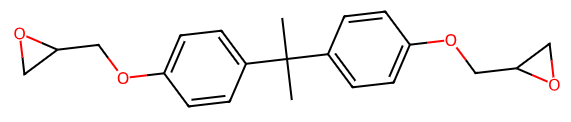  
density = 1.16 g/mL at 25 °C (lit.)  
https://www.sigmaaldrich.com/JP/ja/product/sigma/d3415  


In [ ]:
# NVT-MD (20 ps, Berendsen thermostat at 300 K)
## set parameters NVT-MD
dirout = 'output'
sysname = '30C12H12F12'
fname = f'{sysname}_nvt-eq_{method}'
traj_path = f'{dirout}/{fname}.traj'
log_path = f'{dirout}/{fname}.log'
addlog_path = f'{dirout}/{fname}-add.log'
temp = 300.
dt = 1.0  ## 1 fs
steps = 20000  ## 20 ps
atoms = read('output/30C12H12F12_npt-eq_v6cU0d3.traj', index=-1)
atoms.calc = calculator

## set NVTBerendsen dynamics
dyn = NVTBerendsen(
    atoms=atoms, 
    timestep=dt * units.fs, 
    temperature_K=temp,
    taut=30 * units.fs,
    fixcm=True,
    trajectory=f'{traj_path}', 
    loginterval=100,
    )
dyn.attach(print_dyn, interval=100)
dyn.attach(MDLogger(
            dyn=dyn, atoms=atoms, logfile=f'{log_path}', 
            header=True, stress=True, peratom=False, mode="w"), 
            interval=100
          )
dyn.attach(AddMDLogger(
            dyn=dyn, atoms=atoms, logfile=f'{addlog_path}', 
            header=False, mode="w"),
            interval=100
          ) 

## run MD
Stationary(atoms)
t_start = perf_counter()
dyn.run(steps)

Dyn  step:        0, time[ps]:    0.00, Etot[eV]:  -4883.5644, Epot[eV]:  -4925.0056, Ekin[eV]:   41.4412, T[K]:  296.86, density[g/cm3]: 1.347, calc_time[min]:     0.00
Dyn  step:      100, time[ps]:    0.10, Etot[eV]:  -4883.2876, Epot[eV]:  -4925.0772, Ekin[eV]:   41.7897, T[K]:  299.35, density[g/cm3]: 1.347, calc_time[min]:     0.31
Dyn  step:      200, time[ps]:    0.20, Etot[eV]:  -4883.5948, Epot[eV]:  -4925.6638, Ekin[eV]:   42.0690, T[K]:  301.35, density[g/cm3]: 1.347, calc_time[min]:     0.66
Dyn  step:      300, time[ps]:    0.30, Etot[eV]:  -4883.7616, Epot[eV]:  -4926.5000, Ekin[eV]:   42.7384, T[K]:  306.15, density[g/cm3]: 1.347, calc_time[min]:     1.01
Dyn  step:      400, time[ps]:    0.40, Etot[eV]:  -4883.4198, Epot[eV]:  -4924.9150, Ekin[eV]:   41.4952, T[K]:  297.24, density[g/cm3]: 1.347, calc_time[min]:     1.40
Dyn  step:      500, time[ps]:    0.50, Etot[eV]:  -4883.8352, Epot[eV]:  -4926.2658, Ekin[eV]:   42.4306, T[K]:  303.94, density[g/cm3]: 1.347, calc_

In [ ]:
## check structure
atoms_tmp = read('output/30C12H12F12_nvt-eq_v6cU0d3.traj',index=-1)
get_mol_list(atoms_tmp)[0]
#view_ngl(get_mol_list(atoms_tmp)[0], representations=['ball+stick'], replace_structure=True)

[JP]平衡化過程で意図しない化学反応は起こっていない  
[EN]No undesired chemical reactions occurred in the equilibration process.

## 3. [JP]熱分解シミュレーション
- 昇温速度違い（100, 250, 500 K/ps で 300 K から 2300 K まで）
- 到達温度違い（500 K/ps で 300 K から 2800, 3300, 4300 K まで）

## 3. [EN]Pyrolysis simulations
- Different heating rates（from 300 K to 2300 K by 100, 250, and 500 K/ps）
- Different target temperatures（from 300 K to 2800, 3300, 4300 K by 500 K/ps）

### [JP]昇温速度違い（100, 250, 500 K/ps で 300 K から 2300 K まで）
1) NVT-MD@昇温速度 100 K/ps, 300 K から 2300 K まで, 0.1 fs/step, 25 ps
2) NVT-MD@昇温速度 250 K/ps, 300 K から 2300 K まで, 0.1 fs/step, 25 ps
3) NVT-MD@昇温速度 500 K/ps, 300 K から 2300 K まで, 0.1 fs/step, 25 ps

### [EN]Different heating rates（from 300 K to 2300 K by 100, 250, and 500 K/ps）
1) NVT-MD@heating rate = 100 K/ps, from 300 K to 2300 K, 0.1 fs/step, 25 ps
2) NVT-MD@heating rate = 250 K/ps, from 300 K to 2300 K, 0.1 fs/step, 25 ps
3) NVT-MD@heating rate = 500 K/ps, from 300 K to 2300 K, 0.1 fs/step, 25 ps

In [ ]:
## set NVT-MD print&logger
class PrintWriteLog(MDExtensionBase):
    def __init__(self, fname, dirout='.', stdout=False):
        self.fname   = fname
        self.dirout  = dirout
        self.t_start = perf_counter()
        self.stdout  = stdout
        
    def __call__(self, system, integrator):
        n_step    = system.current_total_step
        sim_time  = system.current_total_time /1000  ## ps
        E_tot     = system.ase_atoms.get_total_energy()
        E_pot     = system.ase_atoms.get_potential_energy()
        E_kin     = system.ase_atoms.get_kinetic_energy()
        temp      = system.ase_atoms.get_temperature()
        density   = system.ase_atoms.get_masses().sum()/units.mol / (system.ase_atoms.cell.volume*(1e-8**3))
        calc_time = (perf_counter() - self.t_start) / 60.  ## min.

        ## write header
        if n_step == 0:
            hdr  = 'step,time[ps],E_tot[eV],E_pot[eV],E_kin[eV],'
            hdr += 'T[K],density[g/cm3],calc_time[min]'
            with open(f'{self.dirout}/{self.fname}.log', 'w') as f_log:
                f_log.write(f'{hdr}\n')
                
        ## write&print result
        line  = f'{n_step:8d},{sim_time:7.2f},'
        line += f'{E_tot:11.4f},{E_pot:11.4f},{E_kin:9.4f},'
        line += f'{temp:8.2f},{density:7.3f},{calc_time:8.2f}'
        with open(f'{self.dirout}/{self.fname}.log', 'a') as f_log:
            f_log.write(f'{line}\n')
        if self.stdout:
            print(line)

In [ ]:
## MD with TempSchedular
def pyrolysis_md(md_params):
    ## set pfp_estimator_fn
    estimator_fn = pfp_estimator_fn(
        model_version=md_params['model_version'], 
        calc_mode=md_params['calc_mode'], 
        )

    ## set system
    system = ASEMDSystem(
        atoms=md_params['atoms'],
        step=0,
        time=0.0,
        )

    ## set integrator
    integrator = NVTBerendsenIntegrator(
        timestep=md_params['timestep'],
        temperature=md_params['temp_start'],
        taut=100.,  ## 100 fs (same as the reference)
        fixcm=True,
        )
    
    ## set MD feature
    md = MDFeature(
        integrator=integrator,
        n_run=md_params['n_run'],
        show_progress_bar=False,
        show_logger=False,
        logger_interval=md_params['logger_interval'],
        estimator_fn=estimator_fn,
        traj_file_name=f"{md_params['dirout']}/{md_params['fname']}.traj",
        traj_freq=md_params['traj_freq'],  ## Trajectory saving frequency
        )

    ## set chedular for temperature rising (as md_extensions)
    step_ext = int( (md_params['temp_target']-md_params['temp_start'])/md_params['kelvin_per_ps']*1000/md_params['timestep'] )  ## temporary
    TempSchedular = TemperatureScheduler(
        start_value=md_params['temp_start'], 
        end_value=md_params['temp_target'],
        num_total_steps=step_ext,  ## Number of steps for the linear temperature change
        )

    ## perform MD simulations with previous settings
    md_results = md(
        system=system,
        extensions=[(TempSchedular, 1), 
                    (PrintWriteLog(fname=md_params['fname'],dirout=md_params['dirout']), md_params['logger_interval'])
                   ]
        )

In [ ]:
## set MD parameter list
dirout = 'output'
sysname = '30C12H12F12'
atoms = read(f'{dirout}/{sysname}_nvt-eq_v6cU0d3.traj', index=-1)
temp_rate_target = [
    [30, 600],  ## 100 K/ps, 2300 K
    [40, 800],  ## 250 K/ps, 2300 K
    [50, 1000],  ## 500 K/ps, 2300 K
]
jobparam_list = []
for kelvin_per_ps, temp_target in temp_rate_target:
    md_params = {
        'model_version': 'v7.0.0', 
        'calc_mode': 'CRYSTAL_U0_PLUS_D3', 
        "atoms": atoms.copy(),
        "timestep": 0.1,  ## fs
        "temp_start": 300,
        "temp_target": temp_target,
        "n_run": 250000,
        "logger_interval": 500,
        "traj_freq": 500,
        "kelvin_per_ps": kelvin_per_ps,
        "dirout": dirout
        }
    tot_ps = int(md_params['n_run'] * md_params['timestep'] / 1000)
    md_params["fname"] = f'{sysname}_nvt-prod_{temp_target}K-{kelvin_per_ps}Kps-{tot_ps}ps'
    jobparam_list.append(md_params)
jobparam_list

In [ ]:
## run MD (-15 hours each)
Parallel(n_jobs=3, backend="threading", verbose=1)(
    delayed(pyrolysis_md)(md_params) for md_params in jobparam_list
    )

### [JP]到達温度違い（500 K/ps で 300 K から 2800, 3300, 4300 K まで）
1) NVT-MD@昇温速度 500 K/ps, 300 K から 2800 K まで, 0.1 fs/step, 25 ps
2) NVT-MD@昇温速度 500 K/ps, 300 K から 3300 K まで, 0.1 fs/step, 25 ps
3) NVT-MD@昇温速度 500 K/ps, 300 K から 4300 K まで, 0.1 fs/step, 25 ps

### [EN]Different target temperatures（from 300 K to 2800, 3300, 4300 K by 500 K/ps）
1) NVT-MD@heating rate = 500 K/ps, from 300 K to 2800 K, 0.1 fs/step, 25 ps
2) NVT-MD@heating rate = 500 K/ps, from 300 K to 3300 K, 0.1 fs/step, 25 ps
3) NVT-MD@heating rate = 500 K/ps, from 300 K to 4300 K, 0.1 fs/step, 25 ps

In [ ]:
## set MD parameter list
dirout = 'output'
sysname = '30C12H12F12'
atoms = read(f'{dirout}/{sysname}_nvt-eq_v6cU0d3.traj', index=-1)
temp_rate_target = [
    [500, 2800],  ## 500 K/ps, 2800 K
    [500, 3300],  ## 500 K/ps, 3300 K
    [500, 4300],  ## 500 K/ps, 4300 K
]
jobparam_list = []
for kelvin_per_ps, temp_target in temp_rate_target:
    md_params = {
        'model_version': 'v6.0.0', 
        'calc_mode': 'CRYSTAL_U0_PLUS_D3', 
        "atoms": atoms.copy(),
        "timestep": 0.1,  ## fs
        "temp_start": 300,
        "temp_target": temp_target,
        "n_run": 250000,
        "logger_interval": 500,
        "traj_freq": 500,
        "kelvin_per_ps": kelvin_per_ps,
        "dirout": dirout
        }
    tot_ps = int(md_params['n_run'] * md_params['timestep'] / 1000)
    md_params["fname"] = f'{sysname}_nvt-prod_{temp_target}K-{kelvin_per_ps}Kps-{tot_ps}ps'
    jobparam_list.append(md_params)
jobparam_list

In [30]:
def run_constant_temp_md(md_params):
    """一定温度でNVT-MDを実行するためのシンプルな関数"""
    estimator_fn = pfp_estimator_fn(
        model_version=md_params['model_version'],
        calc_mode=md_params['calc_mode'],
    )
    system = ASEMDSystem(
        atoms=md_params['atoms'],
        step=0,
        time=0.0,
    )
    integrator = NVTBerendsenIntegrator(
        timestep=md_params['timestep'],
        temperature=md_params['temperature'],  # スケジューラではなく固定温度を指定
        taut=100.,
        fixcm=True,
    )
    md = MDFeature(
        integrator=integrator,
        n_run=md_params['n_run'],
        show_progress_bar=True,
        show_logger=False,
        logger_interval=md_params['logger_interval'],
        estimator_fn=estimator_fn,
        traj_file_name=f"{md_params['dirout']}/{md_params['fname']}.traj",
        traj_freq=md_params['traj_freq'],
    )

    print(f"\n--- 追加計算を開始: {md_params['fname']} ---")
    print(f"ステップ数: {md_params['n_run']} ({md_params['n_run'] * md_params['timestep']/1000:.1f} ps), 維持温度: {md_params['temperature']:.2f} K")

    md_results = md(
        system=system,
        extensions=[
            (PrintWriteLog(fname=md_params['fname'], dirout=md_params['dirout'], stdout=True), md_params['logger_interval'])
        ]
    )
    print(f"--- 追加計算が完了: {md_params['fname']} ---")
    return md_results

# ----------------------------------------------------------------------------------
# メイン処理：各計算の継続ジョブを実行
# ----------------------------------------------------------------------------------
if __name__ == '__main__':
    dirout = 'output'
    sysname = '30C12H12F12'
    
    # 元の計算で使ったパラメータからファイル名を再構築
    temp_rate_target = [
        [30, 600],
        [40, 800],
        [50, 1000],
    ]
    
    original_fnames = []
    for kelvin_per_ps, temp_target in temp_rate_target:
        # n_runとtimestepはファイル名生成にのみ使用
        n_run_original = 250000
        timestep_original = 0.1
        tot_ps = int(n_run_original * timestep_original / 1000)
        fname = f'{sysname}_nvt-prod_{temp_target}K-{kelvin_per_ps}Kps-{tot_ps}ps'
        original_fnames.append(fname)

    # 各計算に対して追加計算を実行
    for base_fname in original_fnames:
        previous_log_path = Path(dirout) / f'{base_fname}.log'
        previous_traj_path = Path(dirout) / f'{base_fname}.traj'

        if not previous_traj_path.exists():
            print(f"スキップ: {base_fname} のトラジェクトリファイルが見つかりません。")
            continue

        try:
            # 1. 前回の計算の最終状態を読み込む
            last_atoms = read(previous_traj_path, index=-1)
            log_df = pd.read_csv(previous_log_path)
            
            if log_df.empty:
                print(f"警告: {base_fname} のログファイルが空です。スキップします。")
                continue
                
            last_temp = log_df['T[K]'].iloc[-1]
            
            print(f"\n======== 継続ジョブの準備: {base_fname} ========")
            print(f"最終温度を読み込みました: {last_temp:.2f} K")

            # 2. 追加計算用のパラメータを設定
            cont_ps = 20.0  # 追加計算時間
            timestep_fs = 0.1 # タイムステップ
            
            cont_params = {
                'model_version': 'v7.0.0',
                'calc_mode': 'CRYSTAL_U0_PLUS_D3',
                "atoms": last_atoms,
                "timestep": timestep_fs,
                "temperature": last_temp,  # 最終温度を維持
                "n_run": int(cont_ps * 1000 / timestep_fs),
                "logger_interval": 500,
                "traj_freq": 500,
                "dirout": dirout,
                "fname": f'{base_fname}_cont_{int(cont_ps)}ps'
            }

            # 3. 追加のMD計算を実行
            run_constant_temp_md(cont_params)

        except Exception as e:
            print(f"エラー: {base_fname} の処理中に問題が発生しました - {e}")


NameError: name 'Path' is not defined

Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x7f835c288310> (for post_run_cell), with arguments args (<ExecutionResult object at 7f833241d910, execution_count=30 error_before_exec=None error_in_exec=name 'Path' is not defined info=<ExecutionInfo object at 7f83342364f0, raw_cell="def run_constant_temp_md(md_params):
    """一定温度でN.." store_history=True silent=False shell_futures=True cell_id=d9fe87bb-dc37-4572-b538-a95b75fd7d96> result=None>,),kwargs {}:


AttributeError: module 'matplotlib' has no attribute 'backends'

In [31]:
import pandas as pd
from ase.io import read
from pathlib import Path
from time import perf_counter

Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x7f835c288310> (for post_run_cell), with arguments args (<ExecutionResult object at 7f8332fa78e0, execution_count=31 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f83344434f0, raw_cell="import pandas as pd
from ase.io import read
from p.." store_history=True silent=False shell_futures=True cell_id=ff0293e2-76f4-4552-bcd5-bc51fabd8393> result=None>,),kwargs {}:


AttributeError: module 'matplotlib' has no attribute 'backends'

In [23]:
## run MD (-15 hours each)
Parallel(n_jobs=3, backend="threading", verbose=1)(
    delayed(pyrolysis_md)(md_params) for md_params in jobparam_list
    )

KeyboardInterrupt: 

Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x7f835c288310> (for post_run_cell), with arguments args (<ExecutionResult object at 7f83306291f0, execution_count=23 error_before_exec=None error_in_exec= info=<ExecutionInfo object at 7f83306295e0, raw_cell="## run MD (-15 hours each)
Parallel(n_jobs=3, back.." store_history=True silent=False shell_futures=True cell_id=c0ca30e6-94e0-4c59-9aab-3fdf230ee3a2> result=None>,),kwargs {}:


AttributeError: module 'matplotlib' has no attribute 'backends'

## 4. [JP]トラジェクトリー解析
- 熱分解シミュレーションで生成した小分子のフラグメントをカウント("get_mol_list")  
1) 昇温速度違い（元論文 Fig. 4）  
2) 到達温度違い（元論文 Fig. 5）

## 4. [EN]Trajectory analysis
- Counting small molecules generated in the pyrolysis simulations ("get_mol_list")  
1) Different heating rates (Fig. 4 in the original paper)
2) Different target temperatures (Fig. 5 in the original paper)

### [JP]昇温速度違い（元論文 Fig. 4）/ Different heating rates (Fig. 4 in the original paper)

In [24]:
## count fragments & return resulting dataframe (get_mol_list)
def count_fragms(l_atoms, ref_fragm):
    for idx, atoms in enumerate(l_atoms):
        d_formula = dict(zip(ref_fragm, np.zeros(len(ref_fragm), dtype=int)))
        d_formula['time[ps]'] = idx * 0.1 * 500 / 1000  ## ps
        d_formula['T[K]'] = atoms.get_temperature()

        l_fragm_atoms = get_mol_list(atoms)[0]
        d_count = Counter([x.get_chemical_formula() for x in l_fragm_atoms])
        for fragm in ref_fragm:
            d_formula[fragm] = d_count[fragm]
            
        if idx == 0:
            df = pd.DataFrame(d_formula, index=[idx])
        else:
            df = pd.concat([df, pd.DataFrame(d_formula, index=[idx])])
    return df

Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x7f835c288310> (for post_run_cell), with arguments args (<ExecutionResult object at 7f83358a2250, execution_count=24 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f836002b4f0, raw_cell="## count fragments & return resulting dataframe (g.." store_history=True silent=False shell_futures=True cell_id=6f485aa4-a2e3-4440-a72a-a1d2059f0def> result=None>,),kwargs {}:


AttributeError: module 'matplotlib' has no attribute 'backends'

In [25]:
from collections import Counter
import pandas as pd
import numpy as np

## Assuming get_mol_list is defined elsewhere

def count_fragms(l_atoms, ref_fragm):
    df_list = [] # Create a list to hold dataframes
    for idx, atoms in enumerate(l_atoms):
        d_formula = dict(zip(ref_fragm, np.zeros(len(ref_fragm), dtype=int)))
        d_formula['time[ps]'] = idx * 0.1 * 500 / 1000  ## ps
        d_formula['T[K]'] = atoms.get_temperature()

        # This block should be indented to be inside the loop
        l_fragm_atoms = get_mol_list(atoms)[0]
        d_count = Counter([x.get_chemical_formula() for x in l_fragm_atoms])
        for fragm in ref_fragm:
            d_formula[fragm] = d_count[fragm]

        df_list.append(pd.DataFrame(d_formula, index=[idx]))

    # Concatenate all dataframes at the end for better performance
    if not df_list:
        return pd.DataFrame() # Return empty dataframe if list is empty
    
    return pd.concat(df_list)

Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x7f835c288310> (for post_run_cell), with arguments args (<ExecutionResult object at 7f8332325490, execution_count=25 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f83323256a0, raw_cell="from collections import Counter
import pandas as p.." store_history=True silent=False shell_futures=True cell_id=024499ec-0ffd-4dd1-a4da-3104b59d88af> result=None>,),kwargs {}:


AttributeError: module 'matplotlib' has no attribute 'backends'

In [26]:
pip install --upgrade --force-reinstall matplotlib

Looking in indexes: https://pypi.org/simple, http://pypi.artifact.svc:8080/simple
  Using cached contourpy-1.3.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (6.3 kB)
  Using cached numpy-2.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 130.3 MB/s eta 0:00:00
Using cached contourpy-1.3.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (321 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 192.3 MB/s eta 0:00:00
Using cached kiwisolver-

AttributeError: module 'matplotlib' has no attribute 'backends'

In [ ]:
## set traj files
l_ftraj_path = [
    'output/30C12H12F12_nvt-prod_2300K-100Kps-25ps.traj',
    'output/30C12H12F12_nvt-prod_2300K-250Kps-25ps.traj',
    'output/30C12H12F12_nvt-prod_2300K-500Kps-25ps.traj',
]
atoms_ini = read('output/30C12H12F12_nvt-eq_v6cU0d3.traj',index=-1)

## set chemical formulas of fragments listed up in the original paper
ref_fragm = ["C39H44O7",  ## original epoxy
           "CH2O",
           "CO",
           "H2O",
           "H2",
           "CH4"
          ]

## get results (~15 min.)
l_rate_df = []
for ftraj in l_ftraj_path:
    l_atoms = [atoms_ini] + read(ftraj, index=':')
    df = count_fragms(l_atoms, ref_fragm)
    l_rate_df.append(df)

In [ ]:
## plot result
fig = plt.figure(figsize=(9,18))

## set fig
for idx, df in enumerate(l_rate_df,1):
    ax1 = fig.add_subplot(len(l_rate_df),1,idx)
    ax2 = ax1.twinx()

    ## plot
    ax1.plot(df['time[ps]'], df['C39H44O7'], label = "C39H44O7", c='#C65D4D')
    ax1.plot(df['time[ps]'], df['CH2O'], label = "CH2O", c='#E66D0F')
    ax1.plot(df['time[ps]'], df['CO'], label = "CO", c='#729238')
    ax1.plot(df['time[ps]'], df['H2O'], label = "H2O", c='#7230A4')
    ax1.plot(df['time[ps]'], df['H2'], label = "H2", c='#0AB450')
    ax1.plot(df['time[ps]'], df['CH4'], label = "CH4", c='#1E4E7E')
    ax2.plot(df['time[ps]'], df['T[K]'], label = "T[K]", linewidth = 2, c='#8BB3E5')
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()    

    ## format
    ax1.set_xlabel("Time /ps", fontsize=16)
    ax1.set_ylabel("Number of fragments", fontsize=16)
    ax2.set_ylabel("T /K", fontsize=16)
    ax1.set_xlim(0,25)
    ax1.set_ylim(0,25)
    ax2.set_ylim(0,2500)
    ax1.legend(h1+h2, l1+l2, loc='upper left', fontsize=14, bbox_to_anchor=(1.14, 1.02))
    ax1.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    
fig.savefig('output/heatingrate_dependency.png', bbox_inches='tight',)

### [JP]到達温度違い（元論文 Fig. 5）/ [EN]Different target temperatures (Fig. 5 in the original paper)

In [ ]:
## read structures
l_traj_path = [
    'output/30C12H12F12_nvt-prod_2800K-500Kps-25ps.traj',
    'output/30C12H12F12_nvt-prod_3300K-500Kps-25ps.traj',
    'output/30C12H12F12_nvt-prod_4300K-500Kps-25ps.traj',
]
atoms_ini = read('output/30C12H12F12_nvt-eq_v6cU0d3.traj',index=-1)

## set chemical formulas of fragments listed up in the original paper
ref_fragm = ["C39H44O7",  ## original epoxy
           "CH2O",
           "CO",
           "H2O",
           "H2",
           "CH4"
          ]

## get results (dataframe)
l_temp_df = []
for traj in l_traj_path:
    l_atoms = [atoms_ini] + read(traj, index=':')
    df = count_fragms(l_atoms, ref_fragm)
    l_temp_df.append(df)

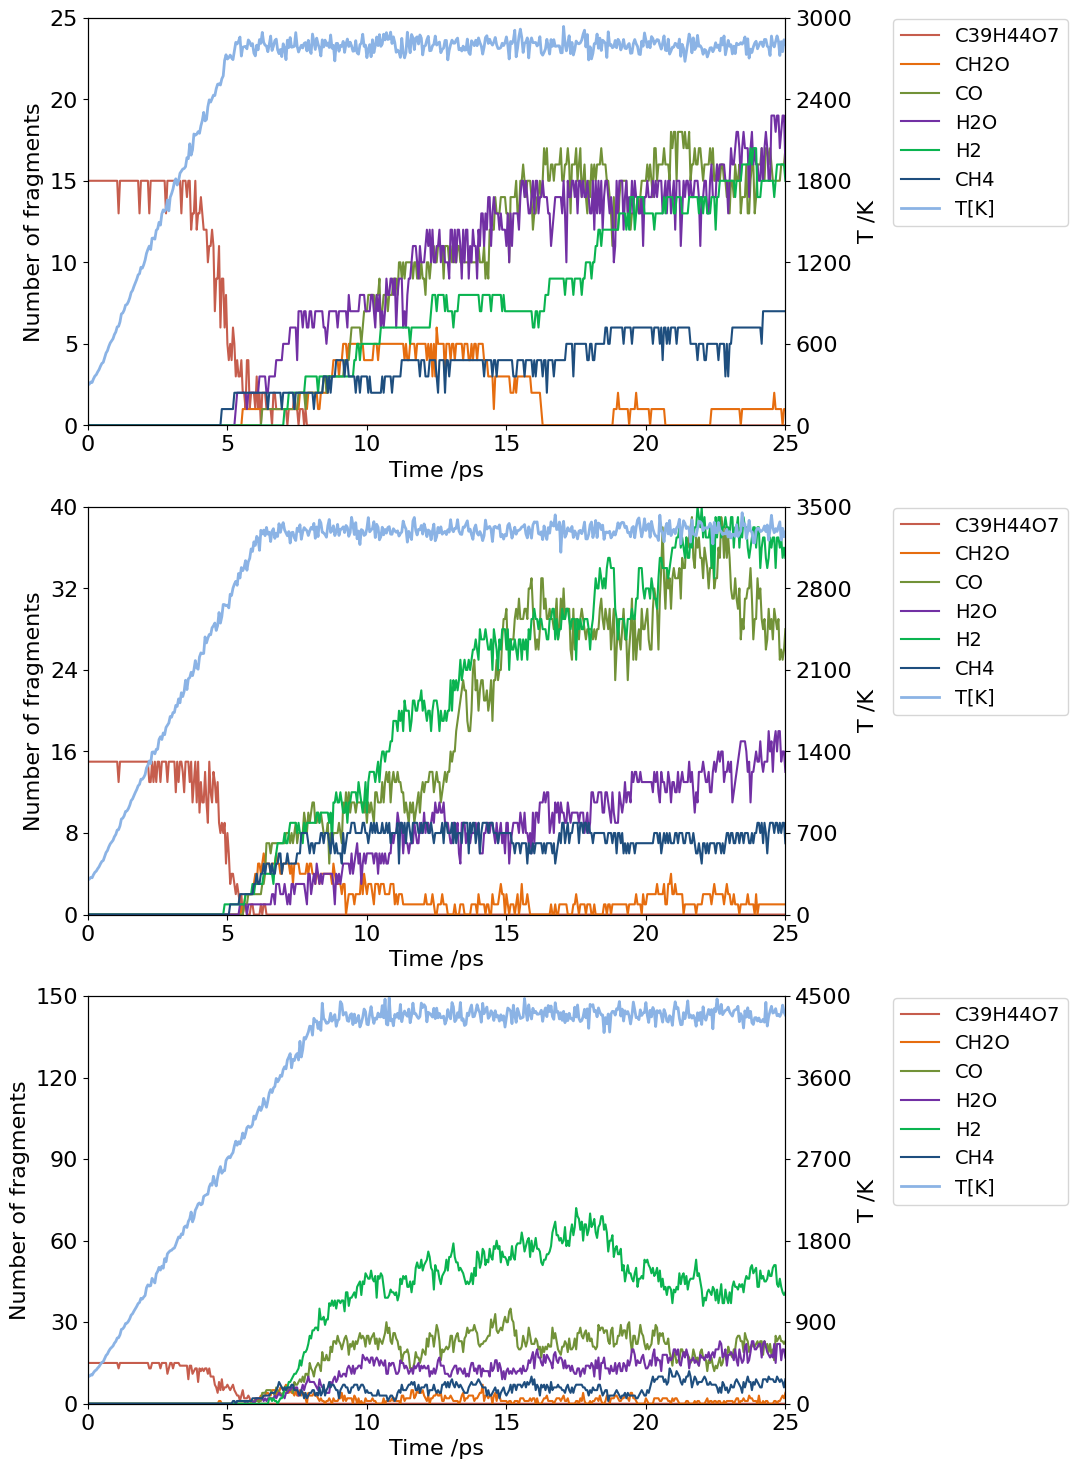

In [24]:
## plot result
l_ylim = [
    [25, 3000],
    [40, 3500],
    [150, 4500],
]

fig = plt.figure(figsize=(9,18))
idx = 0

## set fig
for ylim, df in zip(l_ylim, l_temp_df):
    idx += 1
    ax1 = fig.add_subplot(len(l_ylim),1,idx)
    ax2 = ax1.twinx()

    ## plot
    ax1.plot(df['time[ps]'], df['C39H44O7'], label = "C39H44O7", c='#C65D4D')
    ax1.plot(df['time[ps]'], df['CH2O'], label = "CH2O", c='#E66D0F')
    ax1.plot(df['time[ps]'], df['CO'], label = "CO", c='#729238')
    ax1.plot(df['time[ps]'], df['H2O'], label = "H2O", c='#7230A4')
    ax1.plot(df['time[ps]'], df['H2'], label = "H2", c='#0AB450')
    ax1.plot(df['time[ps]'], df['CH4'], label = "CH4", c='#1E4E7E')
    ax2.plot(df['time[ps]'], df['T[K]'], label = "T[K]", linewidth = 2, c='#8BB3E5')
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()    

    ## format
    ax1.set_xlabel("Time /ps", fontsize=16)
    ax1.set_ylabel("Number of fragments", fontsize=16)
    ax2.set_ylabel("T /K", fontsize=16)
    ax1.set_xlim(0,25)
    ax1.set_ylim(0,ylim[0])
    ax1.set_yticks(np.arange(0, ylim[0]+1, step=ylim[0]/5))
    ax2.set_ylim(0,ylim[1])
    ax2.set_yticks(np.arange(0, ylim[1]+1, step=ylim[1]/5))
    ax1.legend(h1+h2, l1+l2, loc='upper left', fontsize=14, bbox_to_anchor=(1.14, 1.02))
    ax1.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)

fig.savefig('output/temperature_dependency.png', bbox_inches='tight',)